# Predicting the Types of Chest Pain

>## Authors: Derek, Eric, & Selina

### Introduction

Heart disease includes several types of heart conditions which affect the heart. 1 in 12 Canadian above age 20 live with heart disease (Canadian Chronic Disease Surveillance System (CCDSS), 2017). Many factors may cause heart diseases such as high blood pressure, high blood cholesterol, and other behaviours that are harmful to our bodies. A common symptom of heart disease is chest pain. Heart-related chest pain is pressure or tightness generally caused by reduced blood flow to the heart. Our project focuses on factors that lead to chest pain. The four chest pains are classified as, typical angina, atypical angina, non-anginal pain, and asymptomatic chest pain. The predictive question of classification we will answer is: Given the maximum heart rate achieved (thalach) and resting blood pressure (trestbps), can we predict the type of chest pain an individual will have? We downloaded the dataset from the UC Irvine Machine Learning Repository on heart disease (UCI Machine Learning Repository: Heart Disease Data Set, 1988), we will combine two heart disease datasets collected from two different countries, the two areas are Cleveland and Switzerland. The columns are the same but with different data. Since the size of one dataset is smaller, it could be not enough if we use it on predicting the chest pain type.

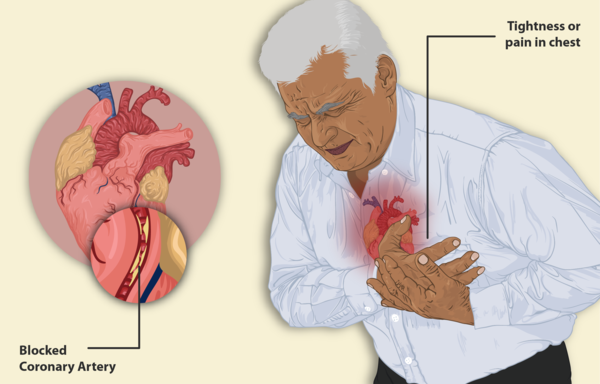

### About the Dataset
This is a grouped dataset from two different areas: Cleveland and Switzerland. This entire database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. Here are the 14 columns used:

1. Age (in years)
2. Sex
    - 1 = male
    - 2 = female
3. Chest Pain Type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
4. Resting Blood Pressure (in mmHg)
5. Cholesterol (serum cholesterol in mg/dl)
6. Fasting Blood Sugar (> 120 mg/dl)
    - 0 = false
    - 1 = true
7. Resting Electrocardiographic Results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. Maximum Heart Rate Achieved (beats per minute)
9. Exercise Induced Angina
    - 1 = yes
    - 0 = no
10. ST depression induced by exercise relative to rest
11. The Slope of the Peak Exercise ST Segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
12. Number of Major Vessels Coloured by Flourosopy
13. Thalassemia
    - Value 3: normal
    - Value 6: fixed defect
    - Value 7: reversable defect
14. Diagnosis of Heart Disease
    - Value 0: < 50% diameter narrowing
    - Value 1: > 50% diameter narrowing

### Methods

Firstly, we combined two datasets from two different areas: Cleveland and Switzerland. The reason for combining two datasets is to increase our dataset size in order to better train our model and create a better classification overall. We will use the maximum achieved heart rate and resting blood pressure columns as predictors because these variables are the most commonly associated measures for chest pain. Blood pressure is associated with heart disease since a higher blood pressure can damage arteries by making them less elastic, decreasing oxygen and blood flow to the heart. In addition, we feel like maximum heart rate achieved would vary based on the person and would be correlated with the health of a heart. Here are the methods we will use:

1. Reading and wrangle the dataset from the web

2. Split the the original dataset into training and testing data

3. Visualize the relationship between predictors and strata by using histograms and scatterplots in the training set

4. Summarise the observations and mean of our predictors and class in the training set

5. Pick an optimal k value using cross validation

6. Build classifier by using the KNN classification algorithm

7. Discuss our expectations, impact of our findings, and future questions this could lead to

### Install and loading packages

In [1]:
#Install the packages for using the function step_upsample
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(dplyr)
library(readxl)
library(tidyverse)
library(themis)
library(GGally)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: recipes


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### Reading, Cleaning, and Wrangling the Dataset

* We were loading two datasets individually from the UCI website
* We read the both dataset by using `read_csv`
* Then we used column names = FALSE becuase there is no column names in the original csv data file, so we used `setNames`to set the names for each column
* Since there are NA in the columns, so we used`drop_na` to drop the NA in the columns we will use
* We used `rbind`to combine two datasets into a single dataframe, since the size on one dataset does not have enough data to predict the class types as there are four cp types, it can decrease the accuracy on our classifier.
* We used `head` to only show 5 rows of the dataset

In [3]:
# Loading the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_data_cl <- read_csv(url, col_names = FALSE, na = c("?")) |>
    setNames(c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
    mutate(cp = as_factor(cp)) |>
    drop_na(trestbps) |>
    drop_na(thalach) |>
    filter(trestbps != 0) |>
    filter(thalach != 0)
#Cleveland's heart disease dataset

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"
heart_disease_data_sw <- read_csv(url, col_names = FALSE, na = c("?")) |>
    setNames(c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
    mutate(cp = as_factor(cp)) |>
    drop_na(age:num) |>
    filter(trestbps != 0) |>
    filter(thalach != 0)
#Switzerland's heart disease dataset

heart_disease_combined_dataset <- rbind(heart_disease_data_cl, heart_disease_data_sw) # use rbind to combine the two datasets
heart_disease_data <- heart_disease_combined_dataset

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(heart_disease_data, n = 5)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


[Table 1.0]

* Table 1.0 prints the five rows of the entire dataframe which combined two datasets to one dataframe

### Selecting Only the Columns Used

* Selected only the columns we will used for predictors and class

In [5]:
heart_disease_dataset <- heart_disease_data |>
select(cp, trestbps, thalach)
head(heart_disease_dataset, n = 5)

cp,trestbps,thalach
<fct>,<dbl>,<dbl>
1,145,150
4,160,108
4,120,129
3,130,187
2,130,172


<div align="center"> Table 1.1: Predictors and predictions </div>

|Chest Pain type | Resting Blood Pressure| Maximum Heart Rate |
|:---------------|:----------------------|-------------------:| 
|1 | 145| 150|
|4 | 160| 108|
|4 | 120| 129|
|3 | 130| 187|
|1 | 130| 172|

* Table 1.1 has our class and predictors columns only and
we are using type of chest pain (cp) as our classifier, resting blood pressure and maximum heart as predictor for this algrithom.

### Splitting the Testing and Training Dataset

* We `set.seed` here for reproducible results as randomly sample
* Based on the dataset, we made a random split of 75% training dataset and 25% testing dataset.
* Classified our class which is cp(chest pain)

In [6]:
set.seed(1)
library(tidymodels)

heart_disease_split <- initial_split(heart_disease_dataset, prop = 0.75, strata = cp)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



### Summarizing & Reporting the Number of Observations and Percentages in Each Class in the Training Set

* We used `group_by+summarize`to caculate the number and percentage of observations from each type of cp class
* We can see that we have four types of chest pain, and the number of observations are unbalanced. Therefore, we will balance our cp class at the recipe step

In [7]:
heart_disease_observations <- heart_disease_train |>
                      group_by(cp) |>
                      summarize(n = n()) |>
                    mutate(percent = 100 * n / nrow(heart_disease_train))
heart_disease_observations

cp,n,percent
<fct>,<int>,<dbl>
1,18,7.964602
2,38,16.814159
3,64,28.318584
4,106,46.902655


* We are using type of chest pain (cp) as our classifier and 

### Summarize the means of the predictor variables & shows how many rows have missing data

<div align="center"> Table 1.2: Precentage of each type of chest pain </div>

|CP | Amount | Percent |
|:--|:-------|--------:| 
|1 |  17|  5.362776|
|2     | 41| 12.933754|
|3 | 78 | 24.605678 |
| 4 | 181| 57.097792|


* We calculated the number of na in for our predictors, which are trestbps and thalach
* We also calculated the mean of predictors which get to know our predictors data better
* We print out the recipe to show our class and predictors, identified how many data points are contained and shows there are no missing data after we drop the NA

In [32]:
heart_disease_exploratory <- read_csv(url, col_names = FALSE, na = c("?")) |>
    setNames(c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
    mutate(cp = as_factor(cp))
#finding the number of na's in trestbps and % of na's in original dataset
trestbps_na <- heart_disease_exploratory |> 
                      filter(is.na(trestbps)) |>
                      summarize(trestbps_na = n()) |>
                      mutate(percent = 100 * trestbps_na / nrow(heart_disease_exploratory))

#finding the number of na's in thalach and % of na's in original dataset
thalach_na <- heart_disease_exploratory |> 
                      filter(is.na(thalach)) |>
                      summarize(thalach_na = n()) |>
                      mutate(percent = 100 * thalach_na / nrow(heart_disease_exploratory))
                
# finding the mean of predictors
predictor_means <- heart_disease_train |>
                      summarize(mean_trestbps = mean(trestbps, na.rm = TRUE), mean_thalach = mean(thalach, na.rm = TRUE))
#Print the recipe
heart_recipe <- recipe(cp ~ trestbps + thalach, data = heart_disease_train, skip = FALSE)|>
                        prep() 

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [42]:
trestbps_na
thalach_na
predictor_means
heart_recipe 

trestbps_na,percent
<int>,<dbl>
2,1.626016


thalach_na,percent
<int>,<dbl>
1,0.8130081


mean_trestbps,mean_thalach
<dbl>,<dbl>
131.8584,149.1106


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Training data contained 226 data points and no missing data.

###  Data Visualization

* Visualized the two predictors individually by using histogram
* Visualized the relationship between two predictors and class by using scatter plot and color the class types

In [43]:
options(repr.plot.width = 10, repr.plot.height = 7)

# histogram for resting blood pressure observations
trestbps_hist <- ggplot(heart_disease_train, aes(x = trestbps)) + 
    geom_histogram(bins = 10) +
    labs(x = "Resting Blood Pressure (mmHg)", y = "Number of Observations",  caption = "[Figure 0.1]") +
    ggtitle("Number of Observations of Resting Blood Pressure (mmHg) in Training Dataset") +
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_y_continuous(breaks = pretty_breaks())
# histogram for maximum heart rate observations
thalach_hist <- ggplot(heart_disease_train, aes(x = thalach)) + 
    geom_histogram(bins = 10) +
    labs(x = "Maximum Heart Rate (beats per minute)", y = "Number of Observations", caption = "[Figure 0.2]") +
    ggtitle("Number of Observations of Max Heart Rate in Training Dataset") +
    theme(plot.title = element_text(hjust = 0.5))+
    scale_y_continuous(breaks = pretty_breaks())
# visualizing the plot for knn
heart_plot <- heart_disease_train |> 
    ggplot(aes(x = trestbps, y = thalach, color = cp)) +
    geom_point(alpha = 0.5) +
    labs(x = "Resting Blood Pressure (mmHg)", 
         y = "Maximum Heart Rate (beats per minute)", 
         color = "Chest Pain Types", 
         caption = "[Figure 0.3]") + 
    scale_color_manual(labels = c("Typical Angina", "Atypical Angina","Non-Anginal Pain","Asymptomatic"), 
                     values = c("orange2", "steelblue2","purple2", "green2")) + 
    theme(text = element_text(size = 12)) +
    ggtitle("Max Heart Rate vs Resting Blood Pressure") + 
    theme(plot.title = element_text(hjust = 0.5))

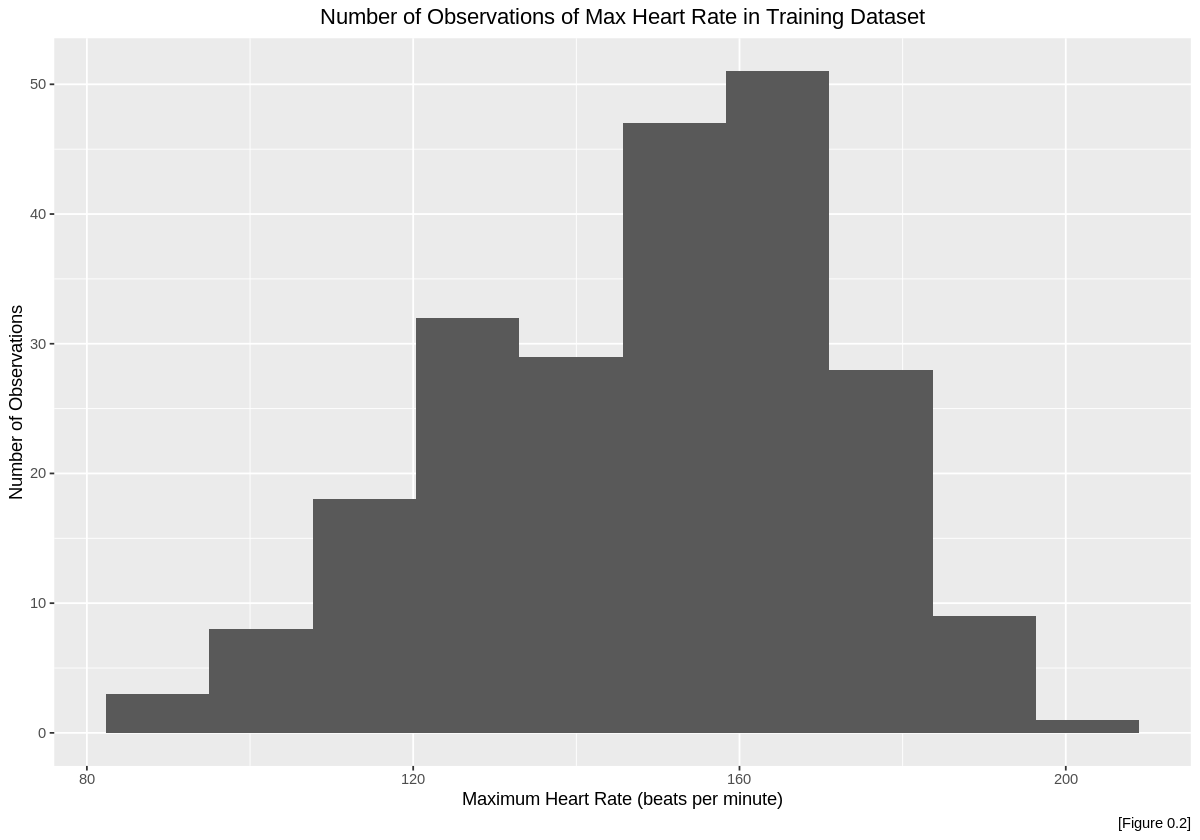

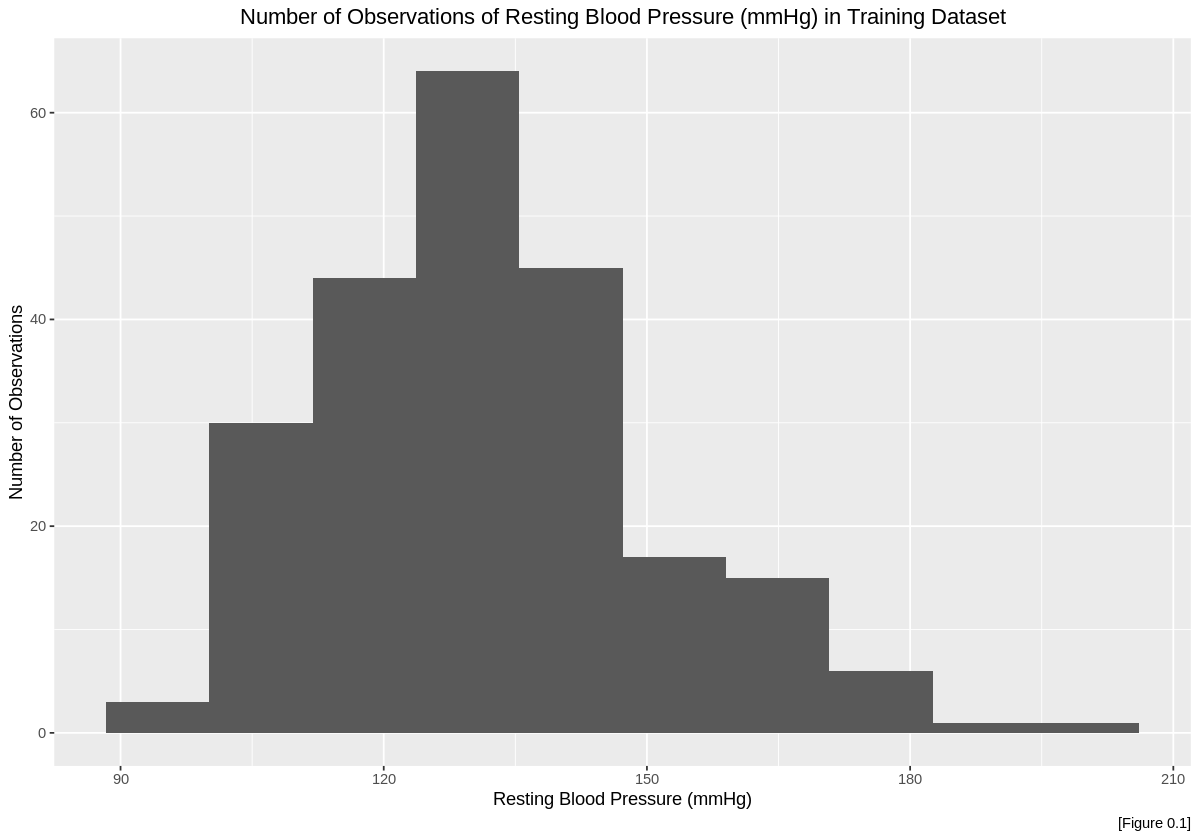

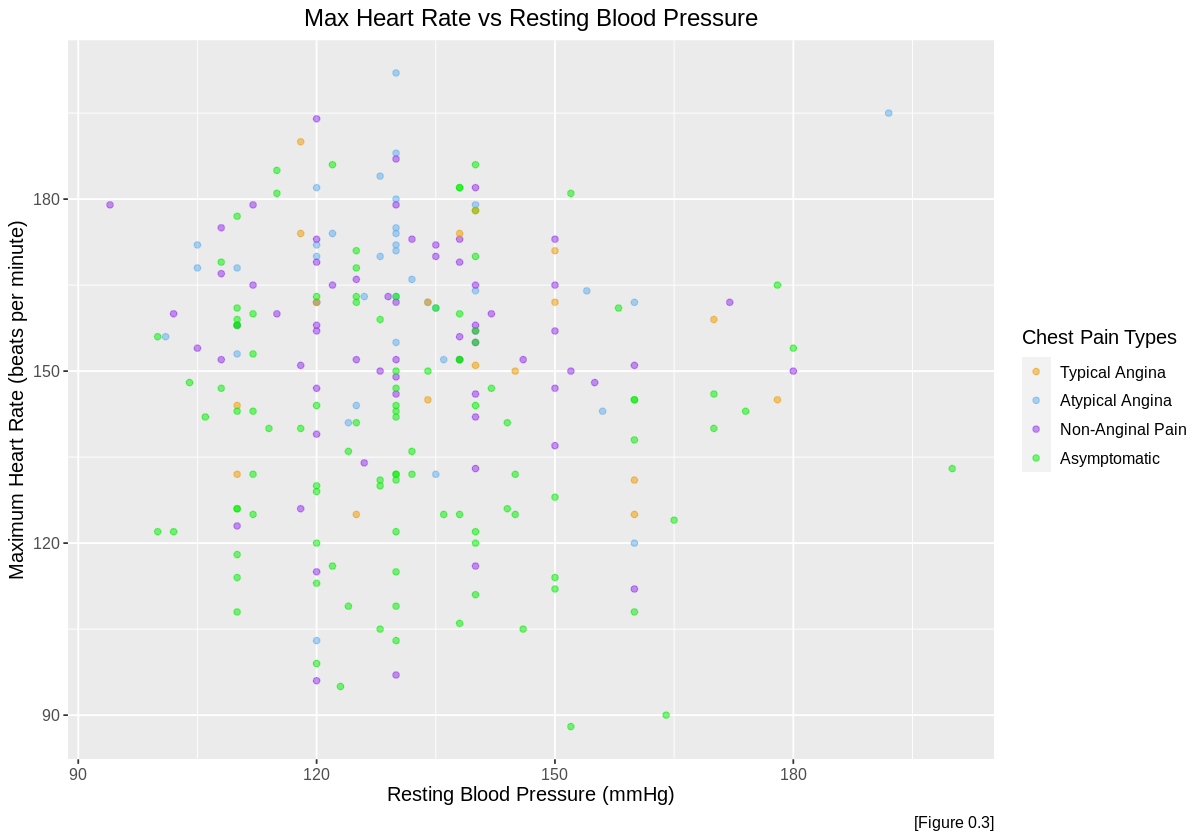

In [44]:
thalach_hist
trestbps_hist
heart_plot

### Expected outcomes and significance

In this project, we will create classifiers that, given a testing set with the predictors of resting blood pressure and maximum achieved heart rate, can predict chest pain type with adequate accuracy. In this process, we also expect to determine whether or not high blood pressure and serum cholesterol have a connection to different types of chest pain.

If we predict which cp type an individual will have based on rbp and serum cholesterol, we could recommend treatment and lifestyle changes corresponding to their cp type before conditions worsens. The four chespains are associated with different severities and treatments. The sooner these cp type are detected and treated, the less risk of patient developing heart disease.

Another question our data analysis lead to is treatment or medication for different types of heart disease. If we predict which cp type someone is susceptible to, then we can analyze how different medications, exercise habits, or changing their diet improve their health could prove beneficial at creating better treatment to heart disease across the world, using data collected relating the health of the individual.

### Building our classifier and Picking the K value

In [45]:
set.seed(1)
# Creating our recipe and scaling, centering, and balancing our predictors
heart_disease_recipe <- recipe(cp ~ thalach + trestbps, data = heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(cp, over_ratio = 1)

In [46]:
heart_disease_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()
Up-sampling based on cp

* We create a reciepe for our algrithom to use. We used thalach and trestbps since these two predictor are the most relevant to determine what type of chest pain the paitient are expirenceing,  which will allow it to result in above average accurices in comparasion to other predictors.
* We scale all of our perdictor to balance out the weight of each predictor so noone predictor can influence the graph too much.

In [47]:
head(heart_disease_train, n = 5)
hd_subset1 <- heart_disease_train %>% select(age:num)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
48,1,2,110,229,0,0,168,0,1.0,3,0,7,1
49,1,2,130,266,0,0,171,0,0.6,1,0,3,0
58,0,1,150,283,1,2,162,0,1.0,1,0,3,0


In [48]:
# work in progress, don't think it can work yet. Hopefully it does though, spent like 3 hours on this thing and had to copy form forest fire at the end lol
hd_subset1 <- heart_disease_train |> 
                select(age, sex, trestbps, chol, thalach, oldpeak, thal, cp)
hd_names <- colnames(hd_subset1 |> select(-cp))

# create an empty tibble to store the results from the function below
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
hd_vfold <- vfold_cv(hd_subset1, v = 5, strata = cp)

# store the total number of predictors to be used in loop
n_total <- length(hd_names)

# stores selected predictors
selected <- c()

# Loop the code for every size from 1 to the total number of predictors
for (x in 1:n_total) {
    # Loop for every predictor still not added yet
    accs <- list()
    models <- list()
    # Recurse for all the value in hd_names
    for (i in 1:length(hd_names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, hd_names[[j]])
        model_string <- paste("cp", "~", paste(preds_new, collapse="+"))

        # create a temparay recipe from the model string to use in the KNN calssification process
        temp_recipe <- recipe(as.formula(model_string), data = hd_subset1) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K value
        accuracy <- workflow() |>
          add_recipe(temp_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = hd_vfold, grid = 1) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        
        # collect the highest temparary accurcy result
        accuracy <- accuracy$mx |>
        unlist()

        # add this result to the dataframe to see which combination of predictor yeal the highest accurices
        accs[[j]] <- accuracy
        models[[j]] <- model_string
    }
    # calculate the highest accuracies for each model
    max_acc <- which.max(unlist(accs))
    accuracies <- accuracies |> 
    add_row(size = i, model_string = models[[max_acc]], accuracy = accs[[max_acc]])
    
    #deselect the jstar colume
    selected <- c(selected, hd_names[[max_acc]])
    names1 <- hd_names[-max_acc]
}
accuracies

ERROR: Error in eval(expr, envir, enclos): object 'j' not found


### Tuning our Knn Classifier

In [49]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")

In [50]:
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


* We set what type of prediction our algrithom will use. In this case we are using knn since we have limited amount of data to work with, and classification because we want to classify something instead of finding a numrical value.
* We choose rectangular since all the value will affect the prediction in a simular way.
* The k amount (neighbors) is set to tune since we want to run a v-fold and determined the best k to use for the highest accurcies later.

In [51]:
set.seed(1)
#Perform 5-fold cross-validation to choose best k
hd_vfold <- vfold_cv(heart_disease_train, v = 5, strata = cp)
gridvals <- tibble(neighbors = seq(1, 30))

hd_results <- workflow() |> 
    add_recipe(heart_disease_recipe) |> 
    add_model(knn_spec)|> 
    tune_grid(resamples = hd_vfold, grid = gridvals) |> 
    collect_metrics() |>
    filter(.metric == "accuracy") 

best_k_values <- hd_results |> 
    select(neighbors, mean)|>
    arrange(desc(mean))

In [52]:
head(best_k_values, n = 5)

neighbors,mean
<int>,<dbl>
2,0.3851687
1,0.3850677
3,0.3631485
27,0.3497765
29,0.3496884


<div align="center"> Table 1.3: Neibourhood accurcies </div>

|neighbors | accurcy |
|:---------|----:|
|2 | 49.84538|
|1 | 49.21046|
|3 | 39.47133 |
|4 | 38.83641|
|5 | 34.44080|


* Table 1.3 reports the five highest mean of K neighbors in a descending order
* We use v-fold to find the best k value that would result in the highest predcition accurcies for our algrithom.
* We take a look at the top 5 k value that result in the highest predcition accurcies in v-fold training.
* In this case we found out that the best k value to use is 2 since that resulted in the most accurcies in our v-fold training.

In [53]:
best_estimated_accuracy <- best_k_values |>
    filter(neighbors == 2) |>
    select(mean) |>
    pull()

In [54]:
best_estimated_accuracy

[1] 0.3851687

* This is the highest accurcie we got in our v-fold training proccess

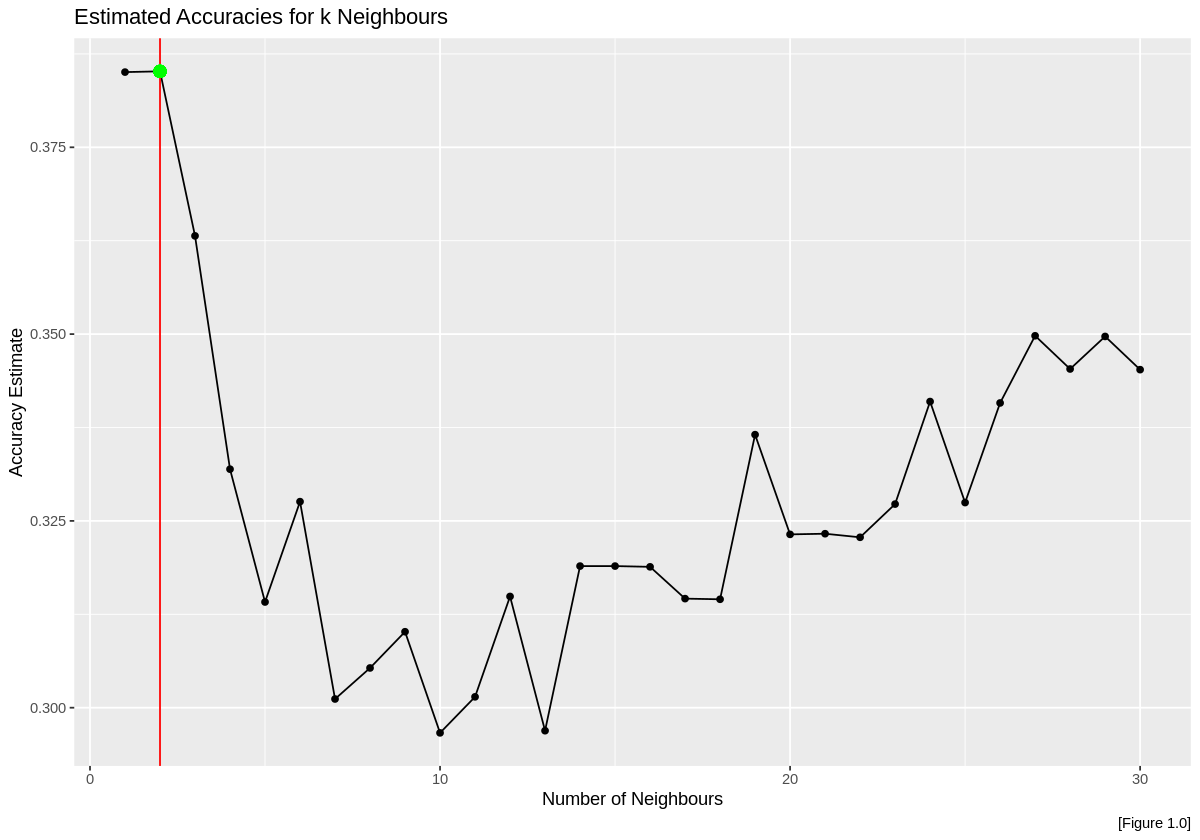

In [55]:
# plot out and look at which value of k is the best 
cross_val_plot <- hd_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 2, colour = "red") +
    geom_point(aes(x = 2, y = best_estimated_accuracy), size = 3, colour = "green") +
    labs(x = "Number of Neighbours", y = "Accuracy Estimate", title = "Estimated Accuracies for k Neighbours", caption = "[Figure 1.0]")
cross_val_plot  

* Visualization of the different value of k according to how accurate they are at predicting the type of chest pain in v-fold algrithom. Visulization makes the value easier to understand on why we choose this value and what it looks like compared to other value.

### KNN Classification by Plugging the Best K Neighbors We Found Above

In [56]:
set.seed(1)
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |> 
    set_engine("kknn") |> 
    set_mode("classification")

heart_disease_fit <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = heart_disease_train)

heart_disease_predictions <- predict(heart_disease_fit, heart_disease_test) |>
    bind_cols(heart_disease_test)

heart_disease_accuracy <- heart_disease_predictions %>% 
    metrics(truth = cp, estimate = .pred_class) %>% 
    select(.metric, .estimate) %>% 
    head(1)

In [57]:
heart_disease_accuracy

.metric,.estimate
<chr>,<dbl>
accuracy,0.3506494


* This table give us the accurcy of our algrithom when predicting the type of chest pain with the 2 predictor in an relaistic senario. As we can see the accuracy is only at an merly 42%. 

### Confusion Matrix 

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



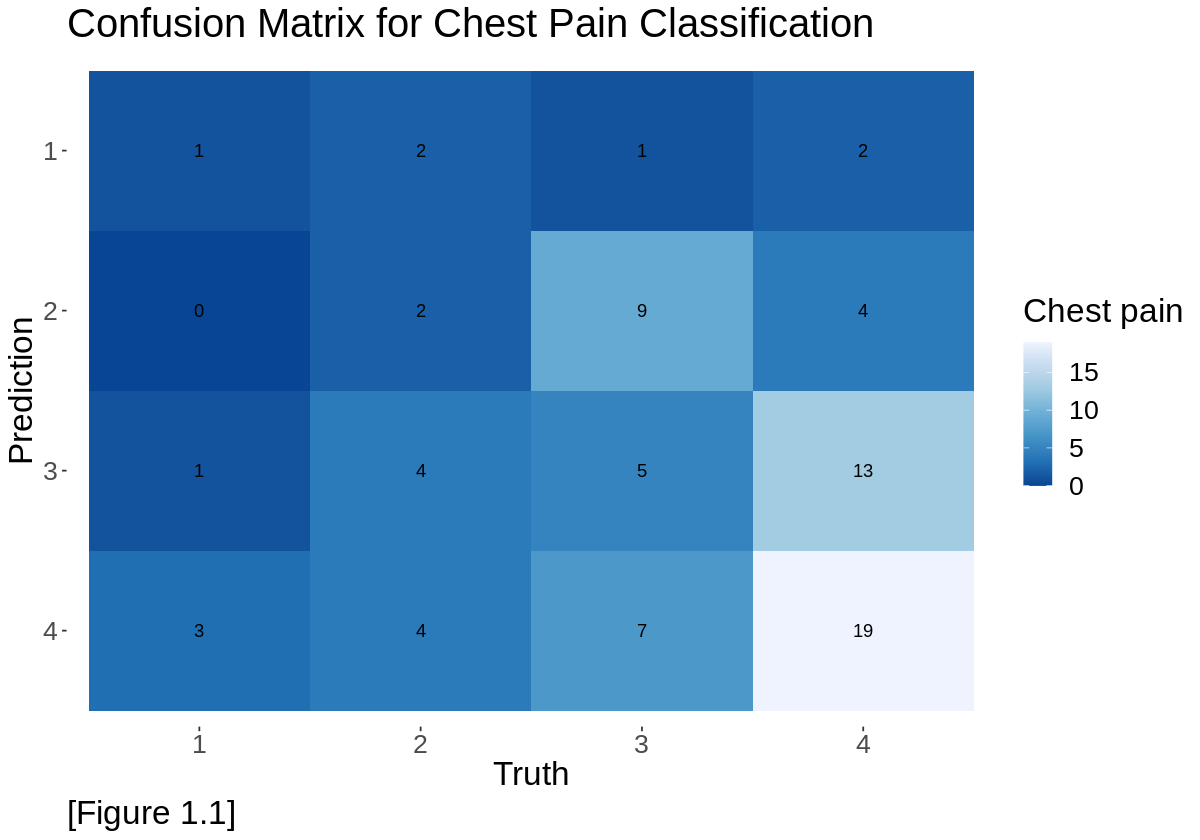

In [58]:
hd_cm <- heart_disease_predictions %>%
    conf_mat(truth = cp, estimate = .pred_class)

autoplot(hd_cm, type = "heatmap") +
    scale_fill_distiller(name = "Chest pain") + 
    labs(title = "Confusion Matrix for Chest Pain Classification", caption = "[Figure 1.1]") +
    theme(legend.position = "right", text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))

* Here we are summarising our observations in a confusion matrix
    * We can see that our model predicted chest pain types 4 (asymptomatic chest pain) well but struggled with the other three types of chest pain (typical angina, atypical angina, and non-anginal pain)
* Overall, our model was able to predict the correct chest pain type when given the resting blood pressure and maximum heart rate achieved `42%` of the time 
    * Out of 107 observations in the testing set, our model was able to predict it correctly 45 times `(45/107)`

### Discussion

Using resting blood pressure (trestbps) and maximum heart rate achieved (thalach), we were able to train a classification model that would produce accurate results `42%` of the time. We used the KNN classification algorithm to build our model and determined that using a k value of 2 (`k = 2`) would produce the highest accuracy. This was determined by performing v-fold classification over 30 possible k values. 

We expected to find some relationship between resting blood pressure and maximum heart rate achieved, which was somewhat seen in our overall accuracy. We would have liked to see an accuracy score greater than `42%` but we acknowledge that we might not have chosen the best predictors. We acknowledge that our question was difficult since it doesn't like there is much pattern between chest pain types and our chosen predictor variables. This is clear in when we look at figure 1.1 since when we compare maximum heart rate vs resting blood pressure, the different types of chest pain seem like they are arranged randomly. This means that if we use a knn approach where we find the closest neighbours to predict the new class, it would have difficulties. In the end, we could have even chosen different predictor variables to see if other variables such as cholesterol would have a greater correlation to the chest pain types. 

However, our model could have potential uses in the future. If the accuracy was greater and doctors were able to predict the type of chest pain a patient would have based off of just their measured resting blood pressure and maximum heart rate achieved, hospitals could prescribe treatments and medicine based off of the predicted chest pain. Even if this just acts as a hint as to what type of chest pain a patient would have, it could lead to faster diagnosis which would lower the chance that someone suffers from heart disease in the future.

Our predictive question of whether or not we can predict chest pain types does raise the following questions:
* How can we increase the accuracy to a point where the of the model matches the accuracy of a doctor's diagnosis and can be used in application?
* How would hospitals across the world implement classification models into their process of diagnosis? 
* Could new studies measure different variables that would replace the current predictors and increase the accuracy of the model?
* How can we educate the public about the risks of heart disease based on the predictors that result in the highest accuracies?

# TEMPORARY NOTE: in the above discussion, replace the figure name with the right figure title, i reference the scatterplot comparing resting bps and max heart rate, coloured by chest pain type -derek

## Citations

   
Canadian Chronic Disease Surveillance System (CCDSS). (2017). https://health-infobase.canada.ca/ccdss/data-tool/Index?G=00 

UCI Machine Learning Repository: Heart Disease Data Set. (1988). https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Wikimedia Foundation. (2022, November 14). Angina. Wikipedia. Retrieved December 3, 2022, from https://en.wikipedia.org/wiki/Angina#/media/File:A_man_having_a_Heart_Attack.png 